In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import signal
from scipy.fft import rfft, rfftfreq
from scipy.fft import fft, fftfreq
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Напишем функцию read_data, который будет приводить dataframe к удобному виду.

In [2]:
def read_data(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    data = data[['time', 'displacements_x', 'displacements_y', 'angular_velocity', 'load_value', 'gear_fault_desc']]
    return data

In [3]:
def read_data_and_choose(path_to_file: str) -> pd.DataFrame:
    data = pd.read_csv(path_to_file, parse_dates=[2])
    data = data.rename(columns={'sensor1': 'displacements_x',
                                'sensor2': 'displacements_y',
                                'time_x': 'time',
                                'speedSet': 'angular_velocity'})
    duration = np.array([round((0.0002 * i), 4) for i in range(data.shape[0])])
    data['time'] = duration
    data['displacements'] = np.sqrt(data['displacements_x']**2 + data['displacements_y']**2)
    data = data[['time', 'displacements_x', 'displacements_y', 'displacements' ,'angular_velocity', 'load_value', 'gear_fault_desc']]
    data = data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 80)]
    data['time'] = data['time'] - data['time'].iloc[0]
    return data

In [4]:
def get_various_params_data(data: pd.DataFrame):
    return (data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 8.33203125) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 25.0) & (data['load_value'] == 80)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 0)],
            data[(data['angular_velocity'] == 40.0) & (data['load_value'] == 80)])

Попробуем классифицировать дефетке при скорости 8 оборотов в секунду без нагрузки

In [5]:
data_eccentricity = read_data_and_choose('eccentricity.csv')
eccentricity_time = data_eccentricity['time']
eccentricity_disp = data_eccentricity['displacements']
data_eccentricity

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
25000,0.0000,2.523958,2.433617,3.506117,8.332031,80,eccentricity
25001,0.0002,2.522808,2.433945,3.505517,8.332031,80,eccentricity
25002,0.0004,2.521987,2.433124,3.504356,8.332031,80,eccentricity
25003,0.0006,2.521987,2.433617,3.504698,8.332031,80,eccentricity
25004,0.0008,2.521987,2.433781,3.504812,8.332031,80,eccentricity
...,...,...,...,...,...,...,...
49995,4.9990,2.522151,2.433781,3.504930,8.332031,80,eccentricity
49996,4.9992,2.521494,2.430168,3.501949,8.332031,80,eccentricity
49997,4.9994,2.521822,2.429675,3.501843,8.332031,80,eccentricity
49998,4.9996,2.521165,2.429675,3.501370,8.332031,80,eccentricity


In [6]:
data_missing_tooth = read_data_and_choose('missing_tooth.csv')
missing_tooth_time = data_missing_tooth['time']
missing_tooth_disp = data_missing_tooth['displacements']
data_missing_tooth

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
25000,0.0000,2.519358,2.429839,3.500184,8.332031,80,missing tooth
25001,0.0002,2.520344,2.429346,3.500551,8.332031,80,missing tooth
25002,0.0004,2.519358,2.429346,3.499841,8.332031,80,missing tooth
25003,0.0006,2.519194,2.430168,3.500293,8.332031,80,missing tooth
25004,0.0008,2.521330,2.429018,3.501033,8.332031,80,missing tooth
...,...,...,...,...,...,...,...
49995,4.9990,2.519687,2.427539,3.498824,8.332031,80,missing tooth
49996,4.9992,2.522151,2.431974,3.503676,8.332031,80,missing tooth
49997,4.9994,2.519523,2.428853,3.499618,8.332031,80,missing tooth
49998,4.9996,2.519523,2.430825,3.500986,8.332031,80,missing tooth


In [7]:
data_no_fault = read_data_and_choose('no_fault.csv')
no_fault_time = data_no_fault['time']
no_fault_disp = data_no_fault['displacements']
data_no_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
25000,0.0000,2.520837,2.431317,3.502274,8.332031,80,No fault
25001,0.0002,2.519030,2.432960,3.502114,8.332031,80,No fault
25002,0.0004,2.520180,2.433945,3.503626,8.332031,80,No fault
25003,0.0006,2.520016,2.433617,3.503280,8.332031,80,No fault
25004,0.0008,2.519851,2.433124,3.502819,8.332031,80,No fault
...,...,...,...,...,...,...,...
49995,4.9990,2.522151,2.429839,3.502194,8.332031,80,No fault
49996,4.9992,2.520508,2.431153,3.501923,8.332031,80,No fault
49997,4.9994,2.522479,2.432139,3.504026,8.332031,80,No fault
49998,4.9996,2.520673,2.430825,3.501814,8.332031,80,No fault


In [8]:
data_root_crack = read_data_and_choose('root_crack.csv')
root_crack_time = data_root_crack['time']
root_crack_disp = data_root_crack['displacements']
data_root_crack

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
25000,0.0000,2.520673,2.430168,3.501358,8.332031,80,Root crack
25001,0.0002,2.520344,2.427539,3.499297,8.332031,80,Root crack
25002,0.0004,2.520673,2.429182,3.500674,8.332031,80,Root crack
25003,0.0006,2.519851,2.429346,3.500196,8.332031,80,Root crack
25004,0.0008,2.521987,2.430332,3.502418,8.332031,80,Root crack
...,...,...,...,...,...,...,...
49995,4.9990,2.523629,2.430825,3.503942,8.332031,80,Root crack
49996,4.9992,2.522479,2.430660,3.503000,8.332031,80,Root crack
49997,4.9994,2.521658,2.430989,3.502637,8.332031,80,Root crack
49998,4.9996,2.522315,2.428525,3.501401,8.332031,80,Root crack


In [9]:
data_surface_fault = read_data_and_choose('surface_fault.csv')
surface_fault_time = data_surface_fault['time']
surface_fault_disp = data_surface_fault['displacements']
data_surface_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
25000,0.0000,2.519194,2.428689,3.499267,8.332031,80,surface defect
25001,0.0002,2.520344,2.426882,3.498842,8.332031,80,surface defect
25002,0.0004,2.518866,2.426718,3.497663,8.332031,80,surface defect
25003,0.0006,2.519687,2.426225,3.497913,8.332031,80,surface defect
25004,0.0008,2.518701,2.429675,3.499597,8.332031,80,surface defect
...,...,...,...,...,...,...,...
49995,4.9990,2.517223,2.429675,3.498533,8.332031,80,surface defect
49996,4.9992,2.521822,2.428853,3.501274,8.332031,80,surface defect
49997,4.9994,2.517387,2.428361,3.497739,8.332031,80,surface defect
49998,4.9996,2.519358,2.429182,3.499727,8.332031,80,surface defect


In [10]:
data_tooth_chipped_fault = read_data_and_choose('tooth_chipped_fault.csv')
tooth_chipped_fault_time = data_tooth_chipped_fault['time']
tooth_chipped_fault_disp = data_tooth_chipped_fault['displacements']
data_tooth_chipped_fault

,time,displacements_x,displacements_y,displacements,angular_velocity,load_value,gear_fault_desc
25000,0.0000,2.519194,2.430496,3.500521,8.332031,80,chipped tooth
25001,0.0002,2.519194,2.430989,3.500864,8.332031,80,chipped tooth
25002,0.0004,2.520016,2.431317,3.501683,8.332031,80,chipped tooth
25003,0.0006,2.519358,2.430496,3.500640,8.332031,80,chipped tooth
25004,0.0008,2.519030,2.430989,3.500745,8.332031,80,chipped tooth
...,...,...,...,...,...,...,...
49995,4.9990,2.522479,2.431646,3.503684,8.332031,80,chipped tooth
49996,4.9992,2.519194,2.430660,3.500636,8.332031,80,chipped tooth
49997,4.9994,2.523958,2.423433,3.499056,8.332031,80,chipped tooth
49998,4.9996,2.522151,2.431482,3.503334,8.332031,80,chipped tooth


In [11]:
params = pd.DataFrame({'defect': ['eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault'],
                      'disp_mean': [eccentricity_disp.mean(), missing_tooth_disp.mean(), no_fault_disp.mean(), root_crack_disp.mean(), surface_fault_disp.mean(), tooth_chipped_fault_disp.mean()],
                      'disp_std': [eccentricity_disp.std(), missing_tooth_disp.std(), no_fault_disp.std(), root_crack_disp.std(), surface_fault_disp.std(), tooth_chipped_fault_disp.std()]})
params = params.sort_values('disp_std')
params

,defect,disp_mean,disp_std
0,eccentricity,3.504256,0.001416
3,root_crack,3.501164,0.001473
2,no_fault,3.502162,0.001605
1,missing_tooth,3.501064,0.001753
5,tooth_chipped_fault,3.500768,0.001864
4,surface_fault,3.498741,0.002947


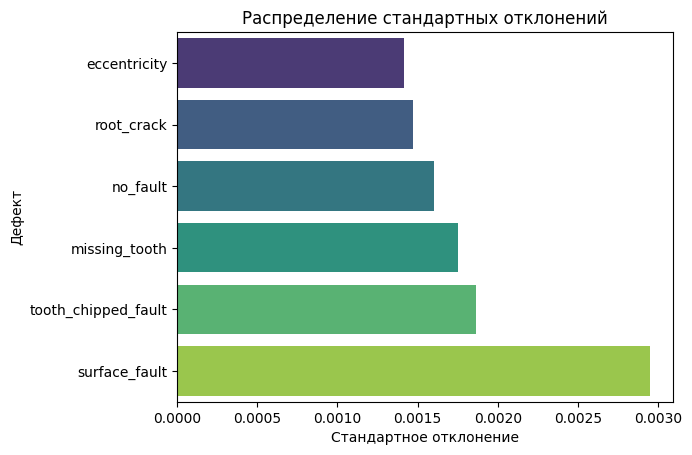

In [12]:
sns.barplot(data=params, y='defect', x='disp_std', palette='viridis')
plt.xlabel('Стандартное отклонение')
plt.ylabel('Дефект')
plt.title('Распределение стандартных отклонений')
plt.show()

In [13]:
params = pd.DataFrame({'defect': ['eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault'],
                      'disp_mean': [eccentricity_disp.mean(), missing_tooth_disp.mean(), no_fault_disp.mean(), root_crack_disp.mean(), surface_fault_disp.mean(), tooth_chipped_fault_disp.mean()],
                      'disp_std': [eccentricity_disp.std(), missing_tooth_disp.std(), no_fault_disp.std(), root_crack_disp.std(), surface_fault_disp.std(), tooth_chipped_fault_disp.std()]})
params = params.sort_values('disp_mean')
params

,defect,disp_mean,disp_std
4,surface_fault,3.498741,0.002947
5,tooth_chipped_fault,3.500768,0.001864
1,missing_tooth,3.501064,0.001753
3,root_crack,3.501164,0.001473
2,no_fault,3.502162,0.001605
0,eccentricity,3.504256,0.001416


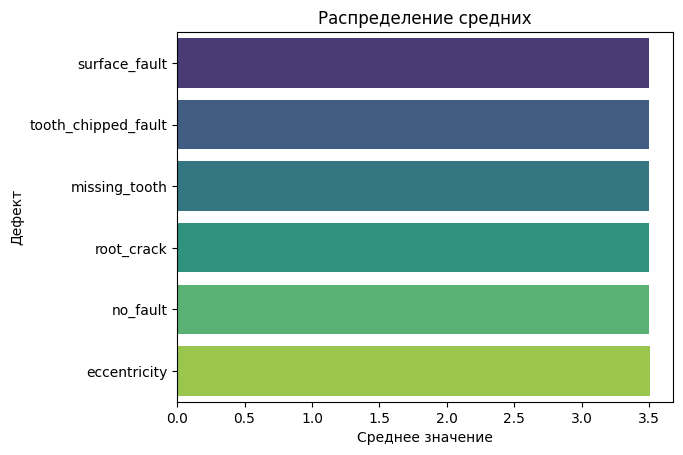

In [14]:
sns.barplot(data=params, y='defect', x='disp_mean', palette='viridis')
plt.xlabel('Среднее значение')
plt.ylabel('Дефект')
plt.title('Распределение средних')
plt.show()

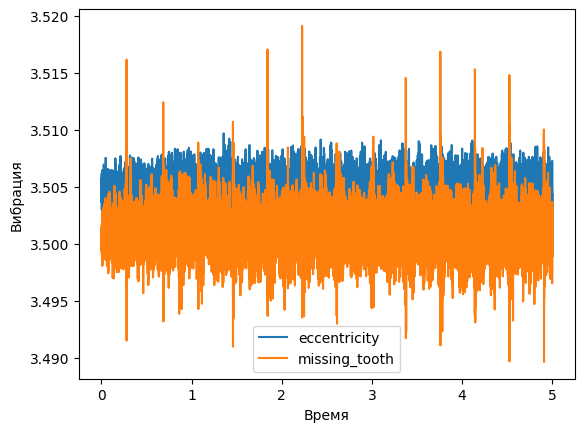

In [15]:
# построим графики попарно 'eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault'
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(missing_tooth_time, missing_tooth_disp, label='missing_tooth')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

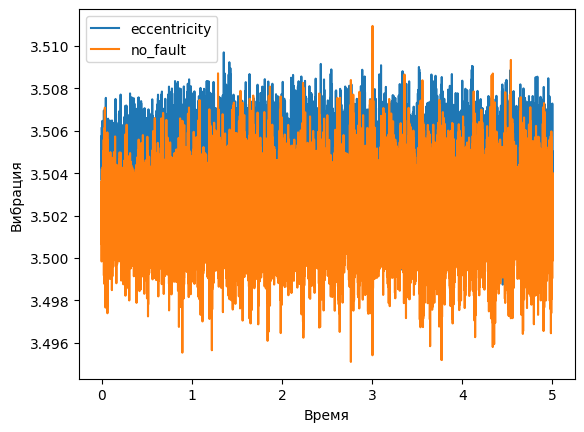

In [16]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(no_fault_time, no_fault_disp, label='no_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

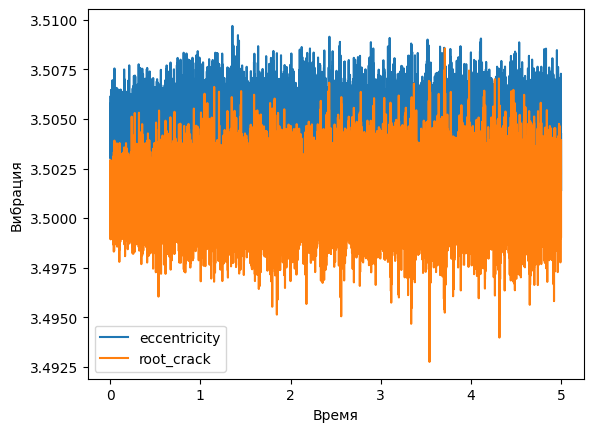

In [17]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(root_crack_time, root_crack_disp, label='root_crack')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

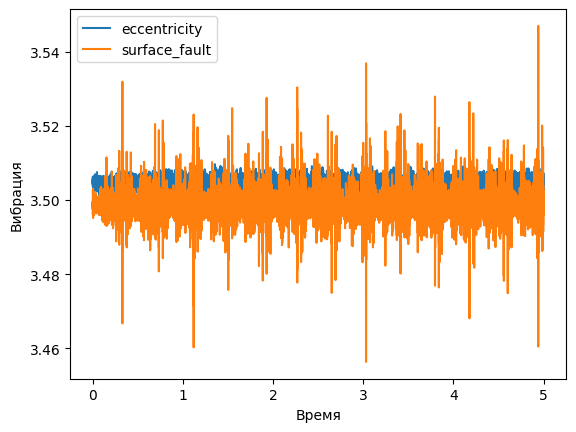

In [18]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(surface_fault_time, surface_fault_disp, label='surface_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

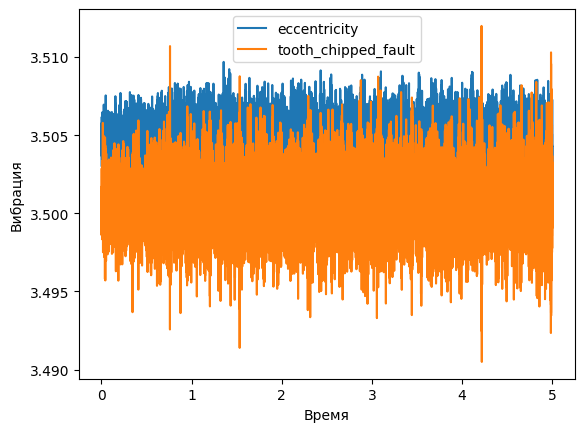

In [19]:
plt.plot(eccentricity_time, eccentricity_disp, label='eccentricity')
plt.plot(tooth_chipped_fault_time, tooth_chipped_fault_disp, label='tooth_chipped_fault')
plt.xlabel('Время')
plt.ylabel('Вибрация')
plt.legend()
plt.show()

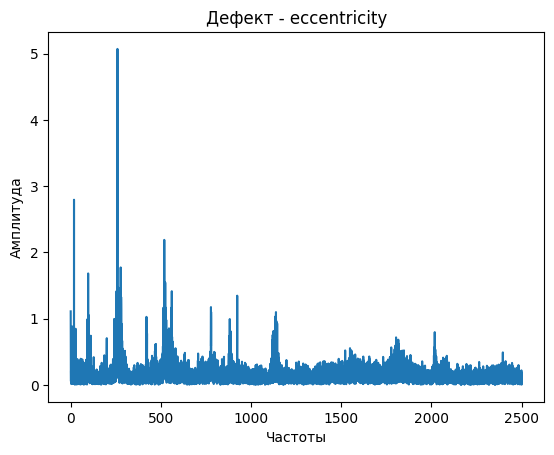

In [20]:
yf = rfft(eccentricity_disp.values)
xf = rfftfreq(n=eccentricity_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - eccentricity')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

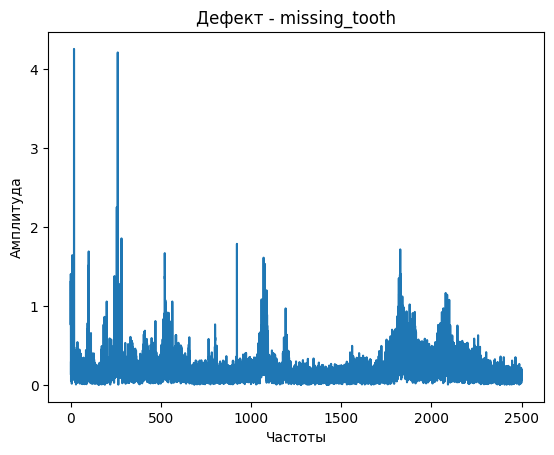

In [21]:
yf = rfft(missing_tooth_disp.values)
xf = rfftfreq(n=missing_tooth_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - missing_tooth')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

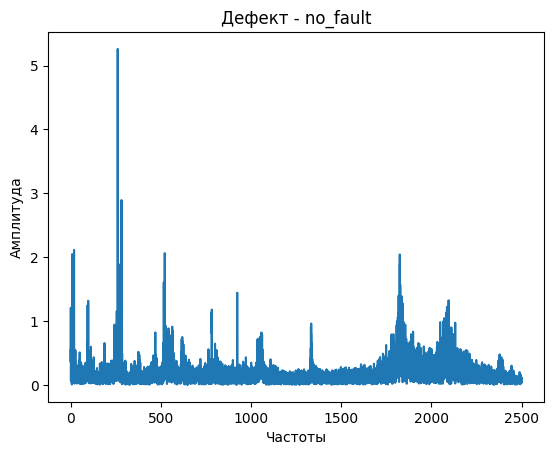

In [22]:
yf = rfft(no_fault_disp.values)
xf = rfftfreq(n=no_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - no_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

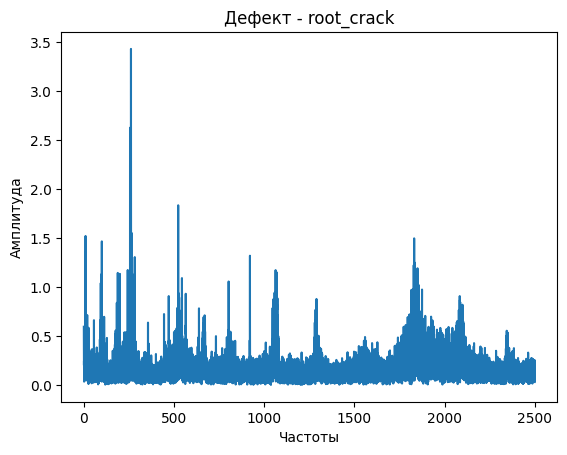

In [23]:
yf = rfft(root_crack_disp.values)
xf = rfftfreq(n=root_crack_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - root_crack')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

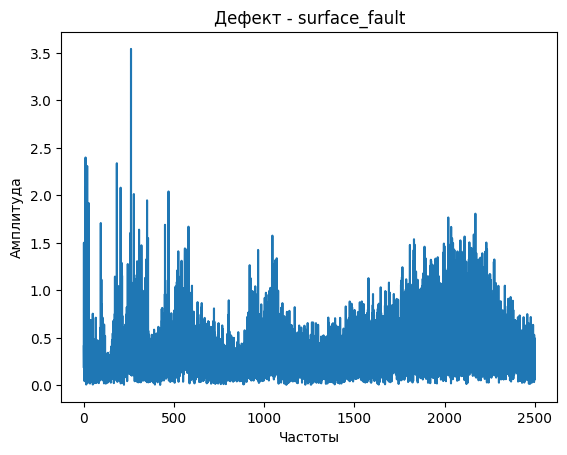

In [24]:
yf = rfft(surface_fault_disp.values)
xf = rfftfreq(n=surface_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - surface_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

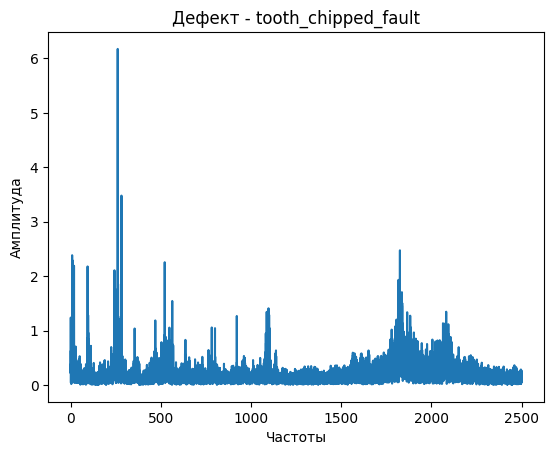

In [25]:
yf = rfft(tooth_chipped_fault_disp.values)
xf = rfftfreq(n=tooth_chipped_fault_disp.values.size, d=0.0002)
plt.plot(xf[1:], np.abs(yf)[1:])
plt.title('Дефект - tooth_chipped_fault')
plt.xlabel('Частоты')
plt.ylabel('Амплитуда')
plt.show()

Попробуем составить обущающую выборку

In [287]:
# 'eccentricity', 'missing_tooth', 'no_fault', 'root_crack', 'surface_fault', 'tooth_chipped_fault'

n_cols = 250
n_rows = 25000 // n_cols

X_1 = data_eccentricity['displacements'].values.reshape(n_rows, n_cols)
y_1 = np.array(['eccentricity' for _ in range(n_rows)])


X_2 = data_missing_tooth['displacements'].values.reshape(n_rows, n_cols)
y_2 = np.array(['missing_tooth' for _ in range(n_rows)])

X_3 = data_no_fault['displacements'].values.reshape(n_rows, n_cols)
y_3 = np.array(['no_fault' for _ in range(n_rows)])

X_4 = data_root_crack['displacements'].values.reshape(n_rows, n_cols)
y_4 = np.array(['root_crack' for _ in range(n_rows)])

X_5 = data_surface_fault['displacements'].values.reshape(n_rows, n_cols)
y_5 = np.array(['surface_fault' for _ in range(n_rows)])

X_6 = data_tooth_chipped_fault['displacements'].values.reshape(n_rows, n_cols)
y_6 = np.array(['tooth_chipped_fault' for _ in range(n_rows)])

X = np.vstack((X_1, X_2, X_3, X_4, X_5, X_6))
y = np.concatenate((y_1, y_2, y_3, y_4, y_5, y_6))
data = pd.DataFrame(X, y).reset_index().rename(columns={'index': 'defect'})

In [288]:
data['mean'] = data.drop(columns='defect').mean(axis=1)
data['std'] = data.drop(columns='defect').std(axis=1)

In [289]:
data.groupby('defect').agg({'std': 'mean'}).reset_index()

,defect,std
0,eccentricity,0.001399
1,missing_tooth,0.001704
2,no_fault,0.001571
3,root_crack,0.001450
4,surface_fault,0.002798
5,tooth_chipped_fault,0.001829


In [290]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [291]:
lr = RandomForestClassifier(n_estimators=1000)
lr.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [292]:
accuracy_score(y_train, lr.predict(X_train))

1.0

In [293]:
accuracy_score(y_test, lr.predict(X_test))

0.7727272727272727

In [294]:
knn = KNeighborsClassifier(n_neighbors=60)
knn.fit(X_train, y_train)
print(accuracy_score(y_train, knn.predict(X_train)))
print(accuracy_score(y_test, knn.predict(X_test)))

0.6343283582089553
0.6212121212121212


In [295]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(X_train, y_train)
print(accuracy_score(y_train, tree.predict(X_train)))
print(accuracy_score(y_test, tree.predict(X_test)))

0.9303482587064676
0.41414141414141414


In [296]:
data

,defect,0,1,2,3,4,5,6,7,8,...,242,243,244,245,246,247,248,249,mean,std
0,eccentricity,3.506117,3.505517,3.504356,3.504698,3.504812,3.504271,3.504779,3.504254,3.505695,...,3.504487,3.504757,3.504635,3.502274,3.505370,3.504470,3.506020,3.503820,3.504444,0.000924
1,eccentricity,3.505285,3.503680,3.504706,3.504543,3.504031,3.504820,3.503102,3.503891,3.503790,...,3.503469,3.503828,3.502743,3.504736,3.503203,3.503570,3.504449,3.505040,3.504276,0.000961
2,eccentricity,3.504491,3.504373,3.504377,3.504850,3.503566,3.505568,3.503790,3.503655,3.505863,...,3.504254,3.504048,3.502523,3.503334,3.505656,3.505568,3.504188,3.504238,3.504454,0.000892
3,eccentricity,3.503929,3.504972,3.503474,3.505302,3.504698,3.505901,3.505644,3.504188,3.504508,...,3.504580,3.506467,3.506932,3.504635,3.502975,3.504271,3.504166,3.503478,3.504383,0.001069
4,eccentricity,3.503680,3.503203,3.505179,3.504499,3.503714,3.501388,3.504149,3.503925,3.504648,...,3.504630,3.503368,3.502908,3.504403,3.502549,3.504727,3.506540,3.505880,3.504238,0.001071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,tooth_chipped_fault,3.498684,3.499091,3.504078,3.500709,3.501265,3.502494,3.500669,3.501265,3.502519,...,3.501341,3.500577,3.502380,3.499153,3.499697,3.498930,3.500897,3.502304,3.500600,0.002018
596,tooth_chipped_fault,3.500619,3.500762,3.500758,3.499592,3.501147,3.501020,3.501011,3.501269,3.502164,...,3.499694,3.497567,3.502633,3.495231,3.499977,3.502772,3.495783,3.503220,3.500889,0.002153
597,tooth_chipped_fault,3.501451,3.497604,3.503089,3.501300,3.502457,3.503090,3.500872,3.502452,3.502025,...,3.499922,3.499141,3.497689,3.501096,3.500428,3.497764,3.498207,3.498272,3.500406,0.002071
598,tooth_chipped_fault,3.500648,3.499280,3.500686,3.499381,3.499885,3.502869,3.499246,3.498846,3.502595,...,3.499344,3.499736,3.498060,3.501336,3.501502,3.499153,3.500424,3.503325,3.500843,0.001964


In [297]:
X = data[['mean', 'std']]
y = data['defect']

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [299]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X_train, y_train)
print(accuracy_score(y_train, tree.predict(X_train)))
print(accuracy_score(y_test, tree.predict(X_test)))

0.35572139303482586
0.2878787878787879


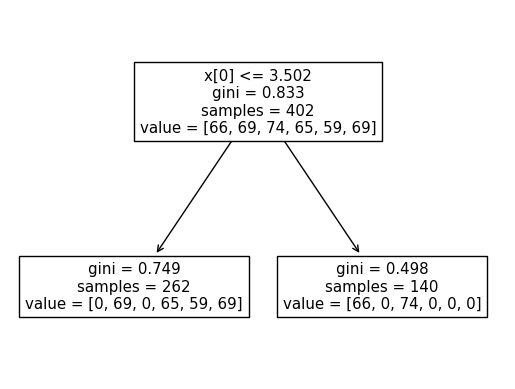

In [300]:
plot_tree(tree)
plt.show()